In [287]:
import os
os.getcwd()
os.chdir(r"C:\Users\91808\Desktop\Hackathon 2\data\thurs")

In [24]:
import pandas as pd
import nltk
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split


C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [82]:
import pandas as pd
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train.shape

(7274, 3)

In [107]:
train['sentiment'].value_counts()

1    4311
2    2382
0     456
3     125
Name: sentiment, dtype: int64

(array([ 456.,    0.,    0., 4311.,    0.,    0., 2382.,    0.,    0.,
         125.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

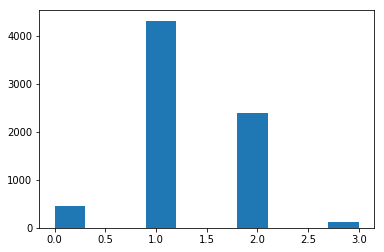

In [112]:
from matplotlib import pyplot as plt

plt.hist(train['sentiment'])

In [290]:
train.iloc[1311,:]

tweet_id                                                  7701
tweet        False Alarm: Google Circles Not Coming NowÛÒa...
sentiment                                                    0
Name: 1311, dtype: object

In [291]:
train.isnull().sum()


tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [300]:
train.dropna(inplace=True)


In [301]:
train.iloc[1311,:]

tweet_id                                                  5260
tweet        RT @mention #sxsw @mention in her 80s splendor...
sentiment                                                    1
Name: 1312, dtype: object

In [302]:
train.isnull().sum()


tweet_id     0
tweet        0
sentiment    0
dtype: int64

In [303]:
train.shape

(7273, 3)

In [304]:
train.iloc[1311,:]

tweet_id                                                  5260
tweet        RT @mention #sxsw @mention in her 80s splendor...
sentiment                                                    1
Name: 1312, dtype: object

In [305]:
train.shape
train['sentiment']

0       1
1       1
2       2
3       0
4       1
5       1
6       1
7       1
8       2
9       2
10      3
11      2
12      2
13      1
14      1
15      1
16      1
17      2
18      1
19      1
20      1
21      1
22      2
23      2
24      0
25      1
26      1
27      1
28      3
29      1
       ..
7244    1
7245    2
7246    1
7247    1
7248    1
7249    1
7250    1
7251    1
7252    2
7253    1
7254    1
7255    2
7256    0
7257    1
7258    2
7259    2
7260    2
7261    2
7262    1
7263    2
7264    1
7265    2
7266    2
7267    3
7268    2
7269    1
7270    1
7271    1
7272    1
7273    1
Name: sentiment, Length: 7273, dtype: int64

In [492]:
#@mention // links // www. // n't // html encoding // lower

tok = nltk.tokenize.WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from string import punctuation

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english') + list(punctuation)

custom = stop_words


negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
def clean_tweet(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    words = [wordnet_lemmatizer.lemmatize(t) for t in words] #lemmatize words
    words = [t for t in words if not any(c.isdigit() for c in t)] # remove digits
    words = [t for t in words if t not in custom] #remove stopwords and punctuation


    return (" ".join(words)).strip()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91808\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91808\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [493]:
train.shape

(7273, 3)

In [494]:
cleaned_tweets = []
count=0
for tweet in train['tweet']:
    z=clean_tweet(tweet)
    if z != None:
        cleaned_tweets.append(clean_tweet(tweet))
    else:
        cleaned_tweets.append(np.nan)
        count+=1  
     

cleaned_df = pd.DataFrame(cleaned_tweets, columns=['text'])
cleaned_df['target'] = train.sentiment
cleaned_df = cleaned_df.dropna() # drop null records
cleaned_df.to_csv('cleaned_train.csv',encoding='utf-8')
print(len(cleaned_tweets))


7273


In [469]:
# wo=cleaned_df.drop(['target'],axis=1)
# a=[list(l) for l in zip(*wo.values)]
# cleaned_tweets=cleaned_tweets[:7272]
# a

In [470]:
# if len(cleaned_tweets)== len(a) and len(cleaned_tweets) == sum([1 for i, j in zip(cleaned_tweets, a) if i == j]): 
#     print ("The lists are identical") 
# else : 
#     print ("The lists are not identical") 


In [471]:
# # for i in range(len(cleaned_tweets)): # assuming the lists are of the same length
#     if cleaned_tweets[i]==a[i]:
#                 print(cleaned_tweets[i])


In [495]:
cleaned_df.shape

(7272, 2)

,tweet_id,tweet,sentiment
7269,3343,@mention Google plze Tammi. I'm in middle of ...,1
7270,5334,RT @mention ÷¼ Are you all set? ÷_ {link} ÷...,1
7271,5378,RT @mention Aha! Found proof of lactation room...,1
7272,2173,We just launched our iPad app at #SXSW! Get al...,1
7273,3162,"The next fin serv battle is vs Apple, GOOG, Mo...",1


In [169]:
import pandas as pd
data=pd.read_csv("cleaned_without removing freq words.csv")
data.tail()

,Unnamed: 0,text,target
7267,7268,google plze tammi middle sxsw craziness everyt...,1
7268,7269,rt set link edchat musedchat sxsw sxswi newtwi...,1
7269,7270,rt aha found proof lactation room excuse mothe...,1
7270,7271,launched ipad app sxsw get detail first editio...,1
7271,7272,next fin serv battle v apple goog mobile opera...,1


In [565]:
# import nltk
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD

# from nltk.corpus import stopwords
# from string import punctuation
# nltk.download('stopwords')
# nltk.download('punkt')
# stop_words = stopwords.words('english')

# custom = stop_words+list(punctuation)
# from nltk.stem import WordNetLemmatizer
# wordnet_lemmatizer = WordNetLemmatizer()
# nltk.download('wordnet')
# import warnings
# warnings.filterwarnings("ignore")
# def my_tokenizer(s):
#     s = str(s)
#     s = s.lower()
#     tokens = nltk.tokenize.word_tokenize(s)
#     tokens = [t for t in tokens if len(t)>2] #remove words lesser than 2 in length
#     tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] #lemmatize words
#     tokens = [t for t in tokens if t not in custom] #remove stopwords and punctuation
#     tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove digits
#     return tokens

In [499]:
# final_text = []
# count = 0
# for x in text:
    
#     final_text.append(my_tokenizer(x))
#     count+=1
#     print (count)

In [64]:
data.head()

,Unnamed: 0,text,target
0,0,sxswnui sxsw apple defining language touch dif...,1
1,1,learning ab google doodle doodle light funny i...,1
2,2,one face ex stealing show yr rt sxsw apple sch...,2
3,3,iphone sxsw app would pretty awesome crash eve...,0
4,4,line outside apple store austin waiting new ip...,1


In [170]:
data.drop(data.columns[0],axis=1,inplace=True)


In [171]:
new = pd.DataFrame(data.text.str.split(expand=True).stack().value_counts())
new.reset_index(level=0, inplace=True)
new.columns = ['word', 'freq']
new = new[(new['freq'] >=200)]
new.drop(38,inplace=True)
new.drop(36,inplace=True)
new.drop(27,inplace=True)
new.drop(8,inplace=True)
new.drop(21,inplace=True)
new.drop(22,inplace=True)
new.drop(35,inplace=True)



new


,word,freq
0,sxsw,7727
1,link,3453
2,ipad,2395
3,rt,2378
4,google,2113
5,apple,1888
6,iphone,1281
7,store,1236
9,austin,795
10,app,672


In [172]:
d = dict(zip(new['word'], new['freq']))


In [173]:
def check_thresh_word(merc,d):
    m = merc.split(' ')
    for i in range(len(m)):
            if m[i] in d.keys():
                return False
    else:
        return True

def rm_freq_occurences(merc,d):
    if check_thresh_word(merc,d) == False:
        nwords = merc.split(' ')
        rwords = [word for word in nwords if word not in d.keys()]
        m = ' '.join(rwords)
    else:
        m=merc
    return m

data['new'] = data['text'].apply(lambda x: rm_freq_occurences(x,d))

In [174]:
data.drop(['text'],axis=1,inplace=True)


In [175]:
data

,target,new
0,1,sxswnui defining language touch different dial...
1,1,learning ab doodle doodle light funny innovati...
2,2,face ex stealing show yr school mkt expert
3,0,would pretty awesome crash every min extended ...
4,1,outside waiting new
5,1,technews lone dude awaits tech news tablet tech
6,1,tip prince npr video toy shopping zuckerberg
7,1,nu user new ubersocial includes uberguide spon...
8,2,free sampler itunes freemusic
9,2,think might go weekend without seeing case twice


In [13]:
data.head()

,target,new
0,1,sxswnui defining language touch different dial...
1,1,learning ab doodle doodle light funny innovati...
2,2,face ex stealing show yr school mkt expert
3,0,would pretty awesome crash every min extended ...
4,1,outside waiting new


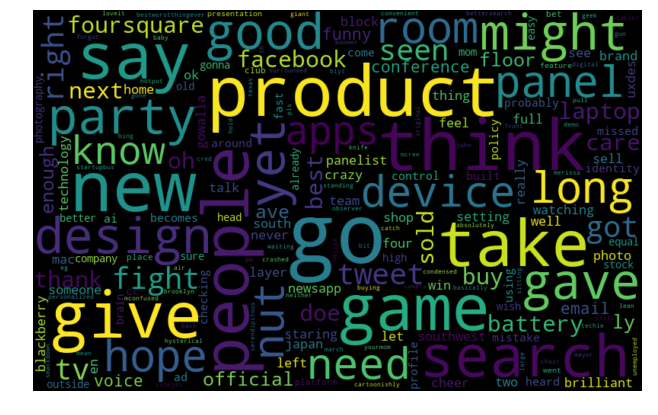

In [158]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 3]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

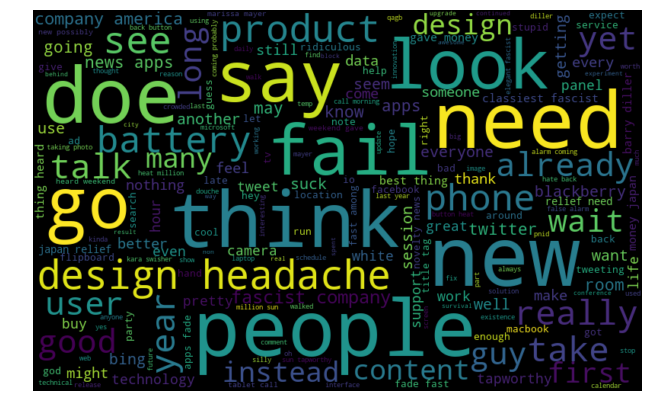

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 0]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

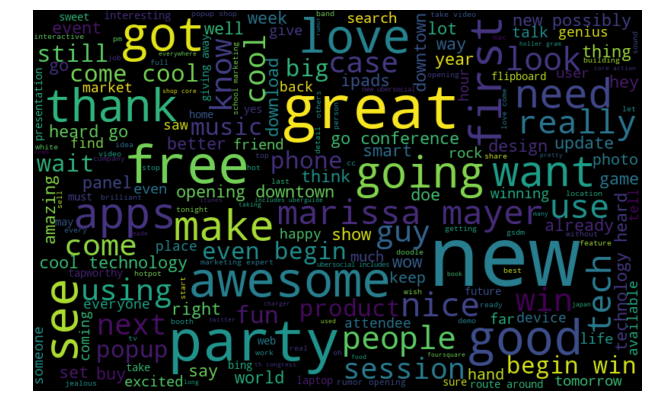

In [159]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 2]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

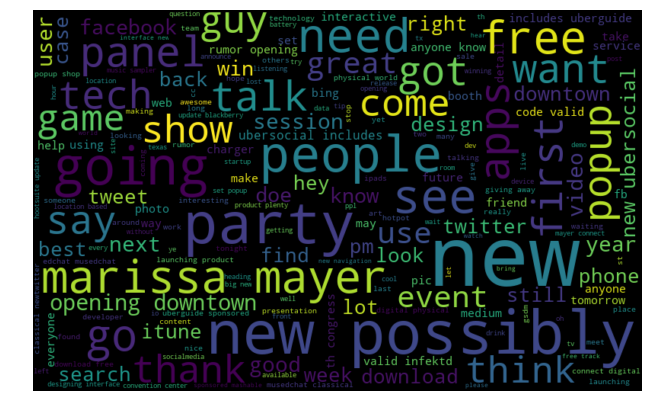

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 1]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [178]:
data.rename(columns= {"new":"tweet"},inplace=True)
data.to_csv("finaldata.csv")


In [19]:
data.head()

,target,tweet
0,1,sxswnui defining language touch different dial...
1,1,learning ab doodle doodle light funny innovati...
2,2,face ex stealing show yr school mkt expert
3,0,would pretty awesome crash every min extended ...
4,1,outside waiting new


In [161]:
X=data['tweet']
y=data['target']

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english")

In [163]:
X=tfidf.fit_transform(X)
X = X.toarray()


In [164]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)


In [165]:
nb=GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)
y_pred

NameError: name 'GaussianNB' is not defined

In [643]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='weighted')  


0.46557529324522423

In [585]:
print (classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.12      0.30      0.17       135
           1       0.68      0.40      0.50      1293
           2       0.41      0.59      0.49       710
           3       0.01      0.02      0.01        44

   micro avg       0.44      0.44      0.44      2182
   macro avg       0.31      0.33      0.29      2182
weighted avg       0.54      0.44      0.47      2182



In [587]:
from sklearn.naive_bayes import MultinomialNB

mb=MultinomialNB()
mb.fit(X_train,y_train)
y_pred=mb.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [588]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.01      0.03       135
           1       0.64      0.95      0.76      1293
           2       0.67      0.25      0.37       710
           3       0.00      0.00      0.00        44

   micro avg       0.64      0.64      0.64      2182
   macro avg       0.49      0.30      0.29      2182
weighted avg       0.64      0.64      0.57      2182



In [352]:
# from sklearn.svm import SVC, LinearSVC
# clf1 = SVC(kernel='linear') #Sequential
# clf1.fit(X_train, y_train)
# clf3 = LinearSVC(class_weight='balanced')

In [596]:
# Perform classification with SVM, kernel=linear
from sklearn import svm
from sklearn.metrics import classification_report

classifier_linear = svm.SVC(kernel='linear',class_weight='balanced')
t0 = time.time()
classifier_linear.fit(X_train,y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test,y_pred, output_dict=True)
# print('positive: ', report['pos'])
# print('negative: ', report['neg'])


Training time: 284.948815s; Prediction time: 90.873605s


In [598]:
print( classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.12      0.30      0.17       135
           1       0.68      0.40      0.50      1293
           2       0.41      0.59      0.49       710
           3       0.01      0.02      0.01        44

   micro avg       0.44      0.44      0.44      2182
   macro avg       0.31      0.33      0.29      2182
weighted avg       0.54      0.44      0.47      2182



In [31]:
clf_model = LogisticRegression()
clf = clf_model.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Model Accuracy: {}'.format(acc))
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average=None)

C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model Accuracy: 0.6617781851512374


NameError: name 'y_pred' is not defined

In [611]:
print( classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.12      0.30      0.17       135
           1       0.68      0.40      0.50      1293
           2       0.41      0.59      0.49       710
           3       0.01      0.02      0.01        44

   micro avg       0.44      0.44      0.44      2182
   macro avg       0.31      0.33      0.29      2182
weighted avg       0.54      0.44      0.47      2182



In [1]:
from imblearn.over_sampling import SMOTE 


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [29]:
from sklearn.metrics import classification_report
from imblearn.pipeline import make_pipeline


In [32]:
SMOTE_pipeline = make_pipeline(tfidf, SMOTE(random_state=777),clf_model)


In [34]:
lr_cv(5, data.tweet, data.target, SMOTE_pipeline, 'weighted')


C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              negative    neutral     positive
precision: [0.34057971 0.74418605 0.5518591  0.        ]
recall:    [0.51086957 0.66821346 0.59119497 0.        ]
f1 score:  [0.40869565 0.70415648 0.5708502  0.        ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.32716049 0.75918367 0.52509653 0.05      ]
recall:    [0.58241758 0.64733179 0.57023061 0.08      ]
f1 score:  [0.41897233 0.69881027 0.54673367 0.06153846]
--------------------------------------------------
              negative    neutral     positive
precision: [0.30625    0.72927461 0.52727273 0.03703704]
recall:    [0.53846154 0.65313225 0.54831933 0.04      ]
f1 score:  [0.39043825 0.68910649 0.53759011 0.03846154]
--------------------------------------------------
              negative    neutral     positive
precision: [0.26190476 0.74016854 0.53846154 0.        ]
recall:    [0.48351648 0.61136891 0.60294118 0.        ]
f1 score:  [0.33976834 0.6696315

In [44]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


In [45]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))


[(0, 3016), (1, 3016), (2, 3016), (3, 3016)]


In [46]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)


0.8837035809018567

In [47]:
y_pred = nb.predict(X_test)


In [49]:
y_pred

array([1, 1, 1, ..., 3, 1, 0], dtype=int64)

In [48]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='weighted')  


0.5788781922467283

In [53]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [54]:
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]


In [55]:
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}


In [56]:
sm = SMOTE()


In [128]:
X_train_res2, y_train_res2 = sm.fit_sample(X_train, y_train)


In [61]:
    for model in models:
        model.fit(X_train_res2, y_train_res2)
        y_pred2 = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred2)
        f1 = f1_score(y_test, y_pred2,average='weighted')
        cm = confusion_matrix(y_test, y_pred2)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)


C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [62]:
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)


MultinomialNB
------------------------------
        Avg. Accuracy: 55.18%
        Avg. F1 Score: 57.83
        Avg. Confusion Matrix: 
        
[[ 72.  21.  31.  11.]
 [143. 718. 349.  83.]
 [ 80. 189. 410.  31.]
 [ 13.  10.  17.   4.]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 62.88%
        Avg. F1 Score: 62.45
        Avg. Confusion Matrix: 
        
[[ 44.  55.  36.   0.]
 [ 52. 938. 294.   9.]
 [ 29. 286. 390.   5.]
 [  5.  21.  18.   0.]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 62.24%
        Avg. F1 Score: 62.98
        Avg. Confusion Matrix: 
        
[[ 72.  33.  26.   4.]
 [ 94. 881. 291.  27.]
 [ 41. 251. 403.  15.]
 [ 13.  15.  14.   2.]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 61.73%
        Avg. F1 Score: 62.43
        Avg. Confusion Matrix: 
        
[[ 64.  35.  33.   3.]
 [ 82. 870. 319.  22.]
 [ 42. 240. 412.  16.]
 [ 11.  15.  17.   1.]]
        
LinearSVC

In [ ]:
from sklearn.ensemble import RandomForestClassifier



In [98]:
rf=RandomForestClassifier()
X=data['tweet'].tolist()+test['tweet'].tolist()
y=data['target']
X[0]
X_test=test['tweet']

# X_test=test['tweet']
# X[:7274]

data['tweet'].shape

(7272,)

In [100]:
X_train=X[:7272]
X_test=X[7272:]

In [101]:
X_test.shape

(1819, 8859)

In [102]:
rf.fit(X_train,y)
y_pred3=rf.predict(X_test)


C:\Users\91808\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [105]:
y_pred3.shape

(1819,)

In [106]:
sat1=pd.DataFrame(y_pred3,columns=['sentiment'])
sat1.to_csv("sat1.csv")


The following command must be run outside of the IPython shell:

    $ pip install tokenizer

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/
